In [1]:
import pandas as pd
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import vaex
vaex.multithreading.thread_count_default = 8
import vaex.ml

In [17]:
sdss = pd.read_csv('/arc/home/aydanmckay/leftjoinpristinespecobjmilliquas.csv',
                   usecols=["CaHK_0_p","pmra_1_p","pmdec_1_p","g_chp_psf_p","r_chp_psf_p","i_chp_psf_p","z_chp_psf_p","y_chp_psf_p","MAG_AUTO_p",
                            "phot_g_mean_mag_1_p","phot_bp_mean_mag_1_p","phot_rp_mean_mag_1_p","CLASS_s","RA_q"])
# sdss

,CaHK_0_p,pmra_1_p,pmdec_1_p,phot_g_mean_mag_1_p,phot_bp_mean_mag_1_p,phot_rp_mean_mag_1_p,g_chp_psf_p,r_chp_psf_p,i_chp_psf_p,z_chp_psf_p,y_chp_psf_p,MAG_AUTO_p,CLASS_s,RA_q
0,21.972,-0.416,-8.462,13.833454,14.202310,13.300272,14.255604,13.802833,13.653096,13.630348,1.358774e+01,15.705700,NaN,NaN
1,25.296,-0.102,-13.107,17.743600,18.087147,17.302958,18.060312,17.742205,17.621430,17.599453,1.757736e+01,18.974701,NaN,NaN
2,25.864,-6.181,-2.274,16.413301,17.041140,15.655658,17.248518,16.378054,16.022442,15.873168,1.576375e+01,19.656700,NaN,NaN
3,26.582,1.104,-6.515,19.234087,19.529345,18.795353,19.505856,19.224485,19.112057,19.110556,1.906391e+01,20.396700,NaN,NaN
4,27.892,NaN,NaN,21.115057,21.349903,20.607525,21.569519,21.110239,20.966051,20.918962,1.000000e+20,20.993000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114335,27.276,10.713,-11.625,17.297626,18.373280,16.282997,18.720415,17.521633,16.682117,16.320166,1.610368e+01,21.466600,NaN,NaN
4114336,27.288,-8.386,-0.360,17.272964,18.256690,16.314653,18.611061,17.372204,16.712685,16.409887,1.622206e+01,21.402901,NaN,NaN
4114337,27.349,0.584,-2.427,18.429705,19.007996,17.783443,19.086988,18.391607,18.108704,17.972933,1.787559e+01,21.098900,NaN,NaN
4114338,27.500,-0.238,-4.205,18.841974,19.580730,18.075872,19.532345,18.820406,18.390047,18.180230,1.807777e+01,21.606300,NaN,NaN


In [20]:
sdss.CLASS_s.value_counts()

STAR      79150
QSO       75940
GALAXY    65401
Name: CLASS_s, dtype: int64

In [3]:
sdss = sdss.loc[(sdss["g_chp_psf_p"] < 1e19) & (sdss["r_chp_psf_p"] < 1e19) & (sdss["i_chp_psf_p"] < 1e19) & \
                        (sdss["z_chp_psf_p"] < 1e19) & (sdss["y_chp_psf_p"] < 1e19) & (sdss["MAG_AUTO_p"] < 95) & \
                        (np.isnan(sdss["pmra_1_p"]) == False) & (np.isnan(sdss["pmdec_1_p"]) == False) & \
                        (np.isnan(sdss["phot_g_mean_mag_1_p"]) == False) & (np.isnan(sdss["phot_bp_mean_mag_1_p"]) == False) & \
                        (np.isnan(sdss["phot_rp_mean_mag_1_p"]) == False) & (np.isnan(sdss['RA_q']) == True)]
sdss.CLASS_s.value_counts()

STAR      74165
GALAXY     9847
QSO         814
Name: CLASS_s, dtype: int64

In [4]:
sdss = sdss.replace({'CLASS_s':np.nan}, -1)
sdss = sdss.replace({'CLASS_s':'STAR'}, 1)
sdss = sdss.replace({'CLASS_s':'GALAXY'}, 2)
sdss = sdss.replace({'CLASS_s':'QSO'}, 3)

In [5]:
# New method where I don't(?) reindex and see what happens.
df_joined = vaex.from_pandas(pd.DataFrame({'PMRA': sdss['pmra_1_p'],
                   'PMDec': sdss['pmdec_1_p'],
                   'G_gaia': sdss["CaHK_0_p"]-sdss['phot_g_mean_mag_1_p'],
                   'B_gaia': sdss["CaHK_0_p"]-sdss['phot_bp_mean_mag_1_p'],
                   'R_gaia': sdss["CaHK_0_p"]-sdss['phot_rp_mean_mag_1_p'],
                   'G_pan': sdss["CaHK_0_p"]-sdss['g_chp_psf_p'],
                   'R_pan': sdss["CaHK_0_p"]-sdss['r_chp_psf_p'],
                   'I_pan': sdss["CaHK_0_p"]-sdss['i_chp_psf_p'],
                   'Z_pan': sdss["CaHK_0_p"]-sdss['z_chp_psf_p'],
                   'Y_pan': sdss["CaHK_0_p"]-sdss['y_chp_psf_p'],
                   'AUTO_cfis': sdss["CaHK_0_p"]-sdss['MAG_AUTO_p']}))
df2 = pd.DataFrame({'Class': sdss['CLASS_s']})

In [6]:
# df_joined = vaex.from_pandas(pd.DataFrame({'PMRA': sdss['pmra_1_p'],
#                    'PMDec': sdss['pmdec_1_p'],
#                    'G_gaia': sdss["CaHK_0_p"]-sdss['phot_g_mean_mag_1_p'],
#                    'B_gaia': sdss["CaHK_0_p"]-sdss['phot_bp_mean_mag_1_p'],
#                    'R_gaia': sdss["CaHK_0_p"]-sdss['phot_rp_mean_mag_1_p'],
#                    'G_pan': sdss["CaHK_0_p"]-sdss['g_chp_psf_p'],
#                    'R_pan': sdss["CaHK_0_p"]-sdss['r_chp_psf_p'],
#                    'I_pan': sdss["CaHK_0_p"]-sdss['i_chp_psf_p'],
#                    'Z_pan': sdss["CaHK_0_p"]-sdss['z_chp_psf_p'],
#                    'Y_pan': sdss["CaHK_0_p"]-sdss['y_chp_psf_p'],
#                    'AUTO_cfis': sdss["CaHK_0_p"]-sdss['MAG_AUTO_p']},
#                    index=np.arange(0,len(sdss))))
# df2 = pd.DataFrame({'Class': sdss['CLASS_s']}, index = np.arange(0,len(sdss)))

In [7]:
df2.Class.value_counts()

-1    3564742
 1      74165
 2       9847
 3        814
Name: Class, dtype: int64

In [8]:
print(df_joined.shape)
df_joined = df_joined.dropna()
print(df_joined.shape)
print(df2.shape)
df2 = df2.dropna()
print(df2.shape)

(3649568, 11)
(3649568, 11)
(3649568, 1)
(3649568, 1)


In [9]:
scaled_star_data = StandardScaler().fit_transform(df_joined)

In [10]:
%%time
fitter = umap.UMAP(verbose=True,n_epochs=200,min_dist=0.0).fit(scaled_star_data, y=df2['Class'])
embedding = fitter.embedding_

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.0, n_epochs=200, verbose=True)
Construct fuzzy simplicial set
Wed Jan 26 07:41:52 2022 Finding Nearest Neighbors
Wed Jan 26 07:41:52 2022 Building RP forest with 64 trees
Wed Jan 26 07:43:00 2022 NN descent for 22 iterations
	 1  /  22
	 2  /  22
	Stopping threshold met -- exiting after 2 iterations
Wed Jan 26 07:47:43 2022 Finished Nearest Neighbor Search
Wed Jan 26 07:49:01 2022 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Jan 26 08:59:29 2022 Finished embedding
CPU times: user 18h 10min 51s, sys: 39min 31s, total: 18h 50min 22s
Wall time: 1h 17min 39s


In [ ]:
redu = pickle.dumps(fitter)
filename = 'semisupervisedspecobjspickle.obj'

with open(filename,'wb') as file_object:
    file_object.write(redu)

In [11]:
df2cmap = df2.replace(-1,0)

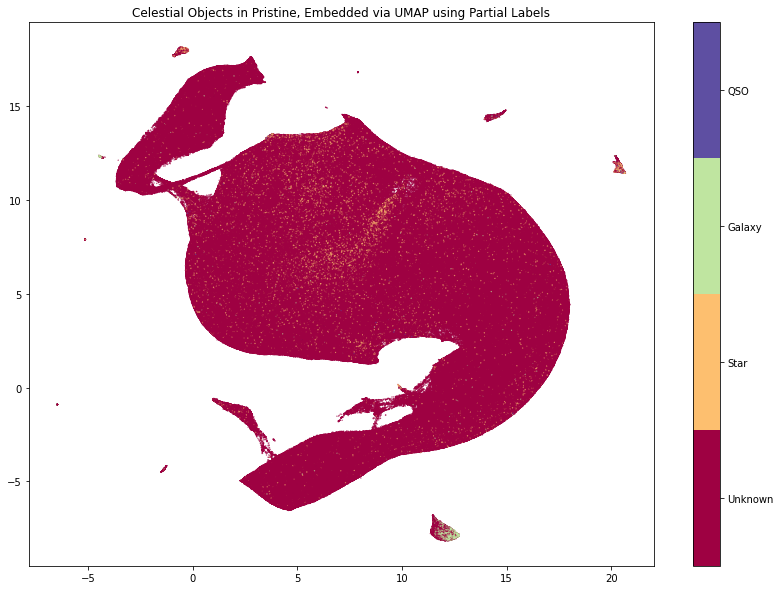

In [12]:
fig, ax = plt.subplots(1, figsize=(14, 10))
cax = ax.scatter(*embedding.T, s=0.1, c=df2cmap['Class'], cmap='Spectral', alpha=1.0)
# ax.set_aspect('equal', 'datalim');
cbar = fig.colorbar(cax, boundaries=np.arange(5)-0.5, ticks=[0, 1, 2, 3]);
cbar.ax.set_yticklabels(['Unknown','Star','Galaxy','QSO']);
ax.set_title("Celestial Objects in Pristine, Embedded via UMAP using Partial Labels")
plt.savefig('/arc/home/aydanmckay/semiquasn_epochs200alph1pmsmindist0hmmm.png')

In [13]:
mask = df2cmap['Class'] != 0

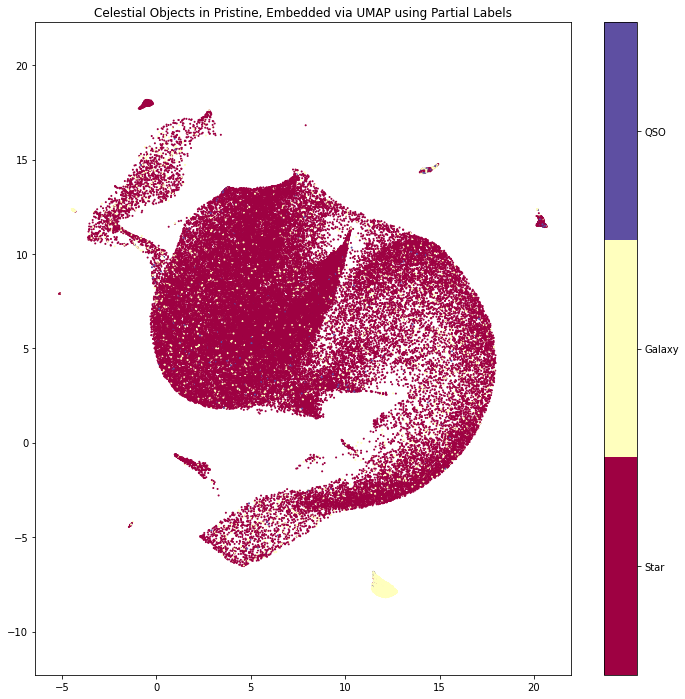

In [14]:
fig, ax = plt.subplots(figsize=(12,12));
cax = ax.scatter(embedding[:,0][mask],embedding[:,1][mask], s=1, c=df2cmap['Class'][mask], cmap='Spectral', alpha=1.0);
ax.set_aspect('equal', 'datalim');
cbar = fig.colorbar(cax, boundaries=np.arange(1,5)-0.5, ticks=[1, 2, 3]);
cbar.ax.set_yticklabels(['Star','Galaxy','QSO']);
ax.set_title("Celestial Objects in Pristine, Embedded via UMAP using Partial Labels");
plt.savefig('/arc/home/aydanmckay/seminounknownsquasn_epochs200alph1pmsmindist0hmmm.png')

In [15]:
sspp = pd.read_csv('/arc/home/aydanmckay/leftjoinpristinesspplamostlrsmilliquas.csv',
                   usecols=["CaHK_0_p","pmra_1_p","pmdec_1_p","g_chp_psf_p","r_chp_psf_p","i_chp_psf_p","z_chp_psf_p","y_chp_psf_p","MAG_AUTO_p",
                            "phot_g_mean_mag_1_p","phot_bp_mean_mag_1_p","phot_rp_mean_mag_1_p","RA_q","AFE_s","FEH_ADOP_s"])

In [16]:
sspp = sspp.loc[(sspp["g_chp_psf_p"] < 1e19) & (sspp["r_chp_psf_p"] < 1e19) & (sspp["i_chp_psf_p"] < 1e19) & \
                        (sspp["z_chp_psf_p"] < 1e19) & (sspp["y_chp_psf_p"] < 1e19) & (sspp["MAG_AUTO_p"] < 95) & \
                        (np.isnan(sspp["pmra_1_p"]) == False) & (np.isnan(sspp["pmdec_1_p"]) == False) & \
                        (np.isnan(sspp["phot_g_mean_mag_1_p"]) == False) & (np.isnan(sspp["phot_bp_mean_mag_1_p"]) == False) & \
                        (np.isnan(sspp["phot_rp_mean_mag_1_p"]) == False) & (np.isnan(sspp['RA_q']) == True)]

In [18]:
sspp = sspp.replace({'AFE_s': np.nan}, -90)
sspp = sspp.replace({'FEH_ADOP_s': [np.nan,-9999.]}, -90)

In [19]:
# New method where I don't(?) reindex and see what happens.
df_joined_fe = vaex.from_pandas(pd.DataFrame({'PMRA': sspp['pmra_1_p'],
                      'PMDec': sspp['pmdec_1_p'],
                      'G_gaia': sspp["CaHK_0_p"]-sspp['phot_g_mean_mag_1_p'],
                      'B_gaia': sspp["CaHK_0_p"]-sspp['phot_bp_mean_mag_1_p'],
                      'R_gaia': sspp["CaHK_0_p"]-sspp['phot_rp_mean_mag_1_p'],
                      'G_pan': sspp["CaHK_0_p"]-sspp['g_chp_psf_p'],
                      'R_pan': sspp["CaHK_0_p"]-sspp['r_chp_psf_p'],
                      'I_pan': sspp["CaHK_0_p"]-sspp['i_chp_psf_p'],
                      'Z_pan': sspp["CaHK_0_p"]-sspp['z_chp_psf_p'],
                      'Y_pan': sspp["CaHK_0_p"]-sspp['y_chp_psf_p'],
                      'AUTO_cfis': sspp["CaHK_0_p"]-sspp['MAG_AUTO_p']}))
df2_afe = pd.DataFrame({'a/Fe': sspp['AFE_s']})
df2_feh = pd.DataFrame({'Fe/H': sspp['FEH_ADOP_s']})

In [20]:
# df_joined_fe = vaex.from_pandas(pd.DataFrame({'PMRA': sspp['pmra_1_p'],
#                       'PMDec': sspp['pmdec_1_p'],
#                       'G_gaia': sspp["CaHK_0_p"]-sspp['phot_g_mean_mag_1_p'],
#                       'B_gaia': sspp["CaHK_0_p"]-sspp['phot_bp_mean_mag_1_p'],
#                       'R_gaia': sspp["CaHK_0_p"]-sspp['phot_rp_mean_mag_1_p'],
#                       'G_pan': sspp["CaHK_0_p"]-sspp['g_chp_psf_p'],
#                       'R_pan': sspp["CaHK_0_p"]-sspp['r_chp_psf_p'],
#                       'I_pan': sspp["CaHK_0_p"]-sspp['i_chp_psf_p'],
#                       'Z_pan': sspp["CaHK_0_p"]-sspp['z_chp_psf_p'],
#                       'Y_pan': sspp["CaHK_0_p"]-sspp['y_chp_psf_p'],
#                       'AUTO_cfis': sspp["CaHK_0_p"]-sspp['MAG_AUTO_p']},
#                       index=np.arange(0,len(sspp))))
# df2_afe = pd.DataFrame({'a/Fe': sspp['AFE_s']}, index = np.arange(0,len(sspp)))
# df2_feh = pd.DataFrame({'Fe/H': sspp['FEH_ADOP_s']}, index = np.arange(0,len(sspp)))

In [21]:
print(df_joined_fe.shape)
df_joined_fe = df_joined_fe.dropna()
print(df_joined_fe.shape)
print(df2_afe.shape)
df2_afe = df2_afe.dropna()
print(df2_afe.shape)
print(df2_feh.shape)
df2_feh = df2_feh.dropna()
print(df2_feh.shape)

(3649568, 11)
(3649568, 11)
(3649568, 1)
(3649568, 1)
(3649568, 1)
(3649568, 1)


In [22]:
scaled_star_data_joined_fe = StandardScaler().fit_transform(df_joined_fe)
embedding_joined_fe = fitter.transform(scaled_star_data_joined_fe)

In [23]:
mask_feh = df2_feh['Fe/H'] > -9

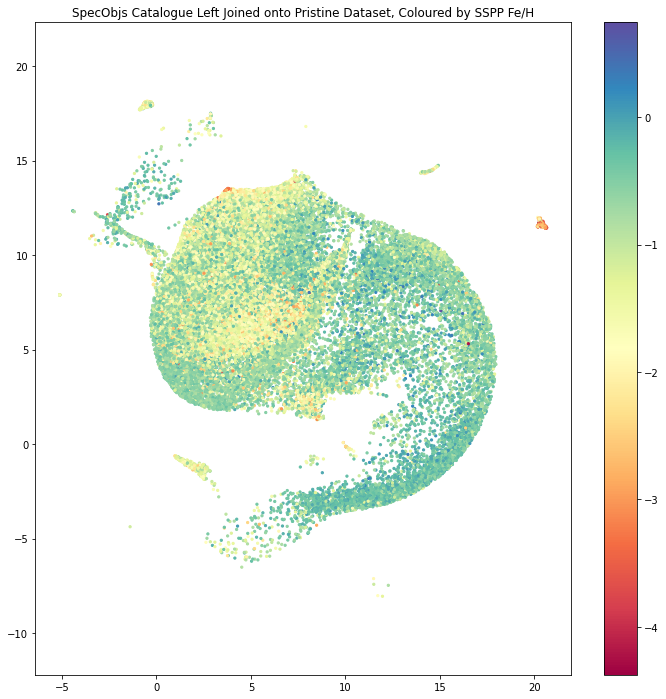

In [24]:
plt.figure(figsize=(12,12))
plt.scatter(embedding_joined_fe[:, 0][mask_feh], embedding_joined_fe[:, 1][mask_feh],c=df2_feh['Fe/H'][mask_feh], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()
plt.title("SpecObjs Catalogue Left Joined onto Pristine Dataset, Coloured by SSPP Fe/H")
plt.savefig('/arc/home/aydanmckay/seminounknownsquasn_epochs200alph1pmsmindist0FEHhmmm.png')